In [1]:
import pandas as pd
from pyspi.calculator import Calculator
import numpy as np
from copy import deepcopy
import glob
import os
import random
import neuromaps
from neuromaps.parcellate import Parcellater
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation
from pathlib import Path
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import statsmodels.stats.multitest
from surfplot import Plot
from surfplot.datasets import load_example_data
from neuromaps.datasets import fetch_fslr

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

objc[85073]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x3048056b8) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x31abd12f8). One of the two will be used. Which one is undefined.
objc[85073]: Class KeyValueObserver is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x3048056e0) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x31abd1320). One of the two will be used. Which one is undefined.
objc[85073]: Class RunLoopModeTracker is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x304805780) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x31abd1370). One of the two will be used. Which one is undefined.


In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in the data and filter to Pearson correlation or directed information (DI) with a Gaussian estimator

In [3]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in all the pyspi homotopic res
all_homotopic_res = pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
pearson_homotopic_res = all_homotopic_res.query("SPI=='cov_EmpiricalCovariance'")
di_gaussian_homotopic_res = all_homotopic_res.query("SPI=='di_gaussian'")

# Compute the mean value for each base_region_to in pearson_homotopic_res
pearson_homotopic_res_mean = (pearson_homotopic_res
                                  .groupby(['Subject', 'base_region_to', 'SPI'])['value'].mean().reset_index()
                                  .groupby("base_region_to")['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region",
                                                   "value": "Mean_Pearson_R"}))

pearson_homotopic_res_for_dk = (pearson_homotopic_res
                                  .groupby(["base_region_to", 'hemi_from'])['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"value": "Mean_Pearson_R"})
                                    )


# Compute the mean value for each base_region_to in di_gaussian_homotopic_res
di_gaussian_homotopic_res_mean = (di_gaussian_homotopic_res
                                  .groupby(['Subject', 'base_region_to', 'SPI'])['value'].mean().reset_index()
                                  .groupby("base_region_to")['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region",
                                                   "value": "Mean_DI_Gaussian"}))

di_gaussian_homotopic_res_for_dk = (di_gaussian_homotopic_res
                                  .groupby(["base_region_to", 'hemi_from'])['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"value": "Mean_DI_Gaussian"})
                                    )

## Visualize the mean Pearson FC from L--R and R--L in the brain (averaged across hemispheres, first)

In [4]:
# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

# Read in the DK atlas
lh_labels, lh_ctab, lh_names = fs.read_annot(lh_dk)
rh_labels, rh_ctab, rh_names = fs.read_annot(rh_dk)

# Some big endian byte-swapping is needed
lh_labels = lh_labels.byteswap().view(lh_labels.dtype.newbyteorder('='))
rh_labels = rh_labels.byteswap().view(rh_labels.dtype.newbyteorder('='))

# Create a lookup table dataframe
lh_names_df = pd.DataFrame({'Region': lh_names, 'Vertex_Value': range(len(lh_names))}).assign(Region = lambda x: x['Region'].str.decode('utf-8'))
rh_names_df = pd.DataFrame({'Region': rh_names, 'Vertex_Value': range(len(rh_names))}).assign(Region = lambda x: x['Region'].str.decode('utf-8'))

# Convert vertices to a DataFrame
lh_labels_df = pd.DataFrame({'Vertex_Value': lh_labels, 'Vertex_Index': range(len(lh_labels))}).merge(lh_names_df, on='Vertex_Value', how='left')
rh_labels_df = pd.DataFrame({'Vertex_Value': rh_labels, 'Vertex_Index': range(len(rh_labels))}).merge(rh_names_df, on='Vertex_Value', how='left')

# Merge with DI Gaussian homotopic res
lh_labels_df_with_DI = lh_labels_df.merge(pearson_homotopic_res_for_dk.query("hemi_from=='left'"), left_on='Region', right_on='base_region_to', how='left')
rh_labels_df_with_DI = rh_labels_df.merge(pearson_homotopic_res_for_dk.query("hemi_from=='right'"), left_on='Region', right_on='base_region_to', how='left')

In [5]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../Brain_Region_Info.csv")

# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

if not os.path.exists("hierarchy_dk_neuromaps_res.csv"):
    nm_atlas_df = pd.read_csv('hierarchy_neuromaps_atlases.csv')

    # Convert the DK atlas to gifti format
    dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
    dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

    # Fit a Parcellator object
    parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

    # Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
    all_dk_neuromaps_res_list = []
    for i, row in nm_atlas_df.iterrows():
        this_row_category = row['Category']
        this_row_desc = row['Description']
        source, desc, space, den = row['Filename'].split('-')

        try:
            print(f"Fetching {source} {desc} {space} {den}")
            this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                                den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))
            
            # Extract this atlas' values in Desikan-Killiany space
            parc_iter = deepcopy(parc)
            this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

            # Create a dataframe
            this_atlas_data_in_dk_df = pd.DataFrame({'Category': this_row_category,
                                                        'Description': this_row_desc,
                                                        'Region_Index': range(len(this_atlas_data_in_dk)),
                                                        'Value': this_atlas_data_in_dk}).merge(brain_region_info, on="Region_Index")
            
            # Append to the list
            all_dk_neuromaps_res_list.append(this_atlas_data_in_dk_df)
        
        except Exception as e:
            print(f"Error parcellating {source} {desc} {space} {den}: {e}")
            continue

    # Concatenate all the dataframes
    hierarchy_dk_neuromaps_res = pd.concat(all_dk_neuromaps_res_list)

    # Save the results
    hierarchy_dk_neuromaps_res.to_csv("hierarchy_dk_neuromaps_res.csv", index=False)

else:
    hierarchy_dk_neuromaps_res = pd.read_csv("hierarchy_dk_neuromaps_res.csv")

hierarchy_dk_neuromaps_res_hemi_avg = hierarchy_dk_neuromaps_res.groupby(['Category', 'Description', 'Base_Region'])['Value'].mean().reset_index()

## How do structural, functional, and transcriptomic measures of the cortical hierarchy correlate with Pearson correlation-based functional connectivity?

In [6]:
# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_pearson = (hierarchy_dk_neuromaps_res_hemi_avg
                              .merge(pearson_homotopic_res_mean, on='Base_Region', how='left')
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: spearmanr(x['Value'], x['Mean_Pearson_R'])).apply(pd.Series)
                              .reset_index()
                              .assign(SPI = 'di_gaussian'))

# Rename the columns for clarity
spearman_corrs_pearson.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

# Display the results
spearman_corrs_pearson['p_val_BH'] = statsmodels.stats.multitest.multipletests(spearman_corrs_pearson.p_value, method="fdr_bh")[1]

# Filter to significant results
spearman_corrs_pearson_sig = spearman_corrs_pearson.query("p_val_BH < 0.05 & abs(Spearman_Correlation) > 0.5")

# Filter neuromaps data to the significant results
hierarchy_dk_neuromaps_res_hemi_avg_sig = hierarchy_dk_neuromaps_res_hemi_avg.merge(spearman_corrs_pearson_sig, on=['Category', 'Description'], how='inner')
hierarchy_neuromaps_vs_pearson_hemi_avg_sig = hierarchy_dk_neuromaps_res_hemi_avg_sig.merge(pearson_homotopic_res_mean, on='Base_Region', how='left')


/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_85073/2956666228.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_pearson = (hierarchy_dk_neuromaps_res_hemi_avg


In [8]:
%%R -i hierarchy_dk_neuromaps_res_hemi_avg_sig

all_ggseg_plots_list <- list()

for (desc in unique(hierarchy_dk_neuromaps_res_hemi_avg_sig$Description)) {
      desc_p <- hierarchy_dk_neuromaps_res_hemi_avg_sig %>%
            filter(Description==desc) %>% 
            mutate(label = glue("lh_{Base_Region}")) %>%
            left_join(., as_tibble(dk)) %>%
            ggseg(atlas = dk, mapping = aes(fill = Value),
                  position = "stacked", colour = "black", hemisphere="left",
                  linewidth=0.5) +
            theme_void() +
            labs(fill = desc) +
            theme(plot.title = element_blank(),
                  legend.position = "bottom") +
            scale_fill_viridis_c(na.value = "white")

      all_ggseg_plots_list[[desc]] <- desc_p
}

wrap_plots(all_ggseg_plots_list, ncol=1)
ggsave("../plots/neuromaps_corrs/Pearson_vs_hierarchy_ggseg_res.svg", width=4, height=7, dpi=300, units="in")


Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The dot-dot notation (`..r.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.label)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 4: The following aesthetics were dropped 

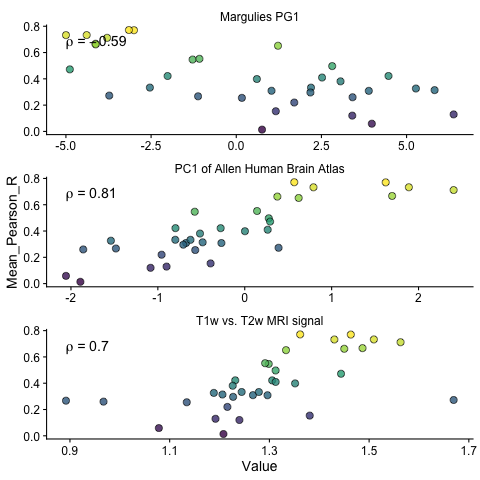

In [14]:
%%R -i hierarchy_neuromaps_vs_pearson_hemi_avg_sig

hierarchy_neuromaps_vs_pearson_hemi_avg_sig %>% 
    ggplot(data=., mapping=aes(x=Value, y=Mean_Pearson_R, fill=Mean_Pearson_R)) +
    geom_point(shape=21, color='black', size=3, alpha=0.8) +
    # Facet wrap but repeat axis titles for each facet
    facet_wrap(Description ~ ., scales="free", ncol=1, axis.labels = 'all') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    theme(legend.position='none') +
    scale_fill_viridis_c() +
    theme(strip.background = element_blank())
# ggsave("../plots/neuromaps_corrs/Hierarchy_maps_with_pearson_correlations_scatters.svg", width=2.25, height=6, dpi=300, units="in")